In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Which super star do you look like the most? 



### 1. Install pacakges ###
Google Colab has installed most of the frequently used packages. For the packages that's not installed, we can use `!pip install ...` to do it.

This project will use the model called 'keras-vggface' that has been trained and shared through GitHub.com. The VGGFace is a face recoginition NN model trained by Visual Geometry Group (VGG) at the University of Oxford. The model was trained using 3.31 million images of 8631 super stars from all over the world.

To earn the credits of this project, you will need to

1. highlight the resnet structures in the VGGFace model after you print the project out.

2. get a final output showing the possibility that you might be the superstar(s). 



Because the 'keras-VGGFace' is only tested on TensorFlow version 1.14, we will need to downgrade both the TensorFlow and the H5PY to accommadate the package. 

In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
import tensorflow as tf
import h5py
print('H5PY version:', h5py.__version__)

#print(keras.__version__)
print('TensorFlow version:', tf.__version__)

H5PY version: 3.1.0
TensorFlow version: 1.15.2


If the version says 
```
H5PY version: 2.10.0
TensorFlow version: 1.15.2
```
skip the next cell.

Otherwise, 
1. run the cell below, 
2. restart the runtime (ctrl+M)
3. Rerun all the cells above
4. check the version requirement again. If satsified, skip the cell below.


In [4]:
!pip uninstall h5py
!pip install h5py==2.10.0

Found existing installation: h5py 3.1.0
Uninstalling h5py-3.1.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/h5py-3.1.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libaec-9c9e97eb.so.0.0.10
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libhdf5-00e8fae8.so.200.0.0
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libhdf5_hl-383c339f.so.200.0.0
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libsz-e7aa62f5.so.2.0.1
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libz-eb09ad1d.so.1.2.3
    /usr/local/lib/python3.7/dist-packages/h5py/*
Proceed (y/n)? y
  Successfully uninstalled h5py-3.1.0
     |████████████████████████████████| 2.9 MB 5.2 MB/s 


Next, we will install face recognition pacakages for this project. 

In [1]:
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install keras_applications
!pip install keras_preprocessing
!pip install mtcnn

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-evc2opto
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-evc2opto
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8325 sha256=71e37b380ed105b23572bf228f7f4db74195129e01a3e81ef01f56947bf1a562
  Stored in directory: /tmp/pip-ephem-wheel-cache-0fm07e9d/wheels/08/df/86/0225d44647ab2256dbf1e006823288fe9cc86367a056e6ea2c
Successfully built keras-vggface
     |████████████████████████████████| 50 kB 3.0 MB/s 
     |████████████████████████████████| 2.3 MB 5.4 MB/s 


We then import the packages here. 

In [13]:
! pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install keras_applications --no-deps
filename = "/usr/local/lib/python3.7/dist-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))
import tensorflow as tf

from keras_vggface.vggface import VGGFace

vggface = VGGFace(model='resnet50') # or VGGFace() as default

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-hgxx1xlh
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-hgxx1xlh
165453824/165439116 [==============================] - 3s 0us/step


In [14]:
import keras
import numpy as np


# check version of keras_vggface
import keras_vggface
# print version
print('keras_VGGFace version:', keras_vggface.__version__)

# confirm mtcnn was installed correctly
import mtcnn
# print version
print('MTCNN version:', mtcnn.__version__)

from matplotlib import pyplot
import matplotlib.image as mpimg
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN
from scipy.spatial.distance import cosine
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from keras_vggface.utils import decode_predictions

keras_VGGFace version: 0.6
MTCNN version: 0.1.0


Please make sure that your package versions are as follows.

keras_VGGFace version: 0.6

MTCNN version: 0.1.0

### 2. Detect faces ###

Before we can perform face recognition, we need to detect faces.

Face detection is the process of automatically locating faces in a photograph and localizing them by drawing a bounding box around their extent.

In this tutorial, we will also use the Multi-Task Cascaded Convolutional Neural Network, or MTCNN, for face detection, e.g. finding and extracting faces from photos. This is a state-of-the-art deep learning model for face detection, described in the 2016 paper titled “Joint Face Detection and Alignment Using Multitask Cascaded Convolutional Networks.”

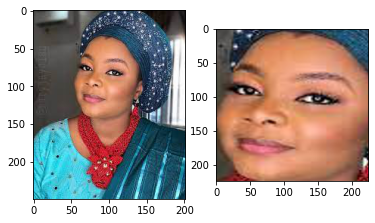

In [16]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(224, 224)):
	# load image from file
	pixels = pyplot.imread(filename)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

## start your code here
image_path='/content/drive/MyDrive/DeepLearningInPractice/Homework9/bimbo.jpg' # you need to change the path to the path of your own image
## end your code here

orig_img = mpimg.imread(image_path)

# load the photo and extract the face
pixels = extract_face(image_path)

fig = pyplot.figure()
# plot the original image
ax = fig.add_subplot(1, 2, 1)
imgplot = pyplot.imshow(orig_img)
# plot the extracted face
ax = fig.add_subplot(1, 2, 2)
imgplot = pyplot.imshow(pixels)

# show the plot
pyplot.show()


### 3. Face identification ###
A VGGFace model can be created using the VGGFace() constructor and specifying the type of model to create via the 'model' argument

`model = VGGFace(model='...')`

The keras-vggface library provides three pre-trained VGGModels, a VGGFace1 model via model=’vgg16′ (the default), and two VGGFace2 models 'resnet50' and 'senet50'.

The example below creates a 'resnet50' VGGFace2 model.

The first time that a model is created, the library will download the model weights and save them in the ./keras/models/vggface/ directory in your home directory. The size of the weights for the resnet50 model is about 158 megabytes, so the download may take a few minutes depending on the speed of your internet connection.



In [17]:
# create a vggface model
model = VGGFace(model='resnet50')

If printing out the NN structure, we can observe the apparant 'resnet' structure (looks like a jump from bottom layers to several layers above). 

**Exercise**: Can you find the 'resnet' structure (jumps) in the VGGFace model? 

***After you print out your output, please highlight the 'resnet' structure in the model to earn points. ***

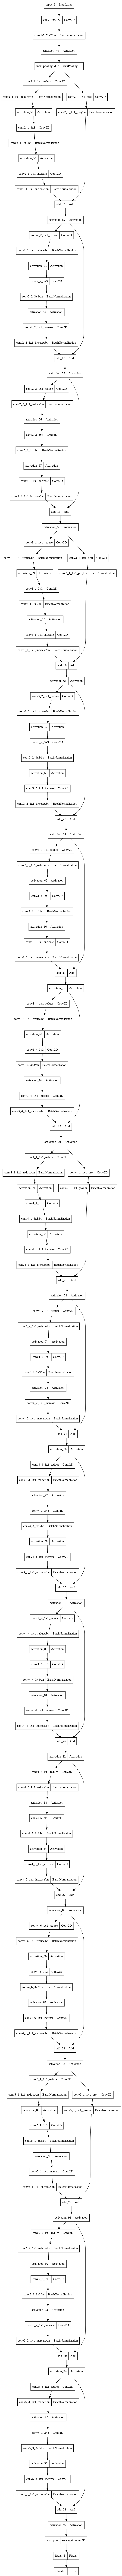

In [18]:
tf.keras.utils.plot_model(model, show_shapes=False)

Before we can make a prediction with a face, the pixel values must be scaled in the same way that data was prepared when the VGGFace model was trained. Specifically, the pixel values must be centered on each channel using the mean from the training dataset.

In [19]:
# convert one face into samples
pixels = pixels.astype('float32')
samples = np.expand_dims(pixels, axis=0)
# prepare the face for the model, e.g. center pixels
samples = preprocess_input(samples, version=2)

# perform prediction
yhat = model.predict(samples)
# convert prediction into names
results = decode_predictions(yhat)
# display most likely results
for result in results[0]:
	print('%s: %.3f%%' % (result[0], result[1]*100))

1359872/1346516 [==============================] - 0s 0us/step
b' Da_Brat': 15.534%
b' Demetria_McKinney': 8.036%
b' Raven-Symon\xc3\xa9': 7.749%
b' Gabrielle_Union': 4.427%
b' Cris_Vianna': 3.891%
